# Hannah Bish

Homework #1
===========

**How to submit:** Fork the homeworks git repository and write your homework in an IPython notebook in a directory named `hw1/$NAME`, replacing `$NAME` with your name w/o any spaces (i.e., `hw1/MarioJuric`). To submit, issue a pull request.

Problem 1: Querying and data analysis with SDSS
===============================================

Open an account on the SDSS Catalog Access Service (CAS) website, http://skyserver.sdss.org/CasJobs/. The documentation for CAS is at http://skyserver.sdss.org/casjobs/Guide.aspx, and the documentation showing the contents of various *tables* and *views* -- also known as the *schema browser* -- is at http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx. As we've discussed, you may think of "views" (below) as tables.

Tasks
-----
1
-----

Use the schema browser to familiarize yourself with the contents of a view named `Star`. Then:
   * Write (and execute) an SQL query to count how many stars have been observed with SDSS (in the current Data Release 12).

    SELECT
      COUNT(*)
    FROM
      Star
    WHERE
      probPSF = 1
    INTO
      mydb.hw1_count

*This query counts the number of objects in the `Star` view with `probPSF = 1`, which means that the object is marked as a star (as opposed to a galaxy or some other object). It returns a count of **260,562,744**.*

   * Write (and execute) an SQL query to count how many observations there are in `u`, `g`, `r`, `i` and `z` bands, and the average observed magnitude in each band. How does the SDSS database record missing (magnitude) data?

    SELECT
        COUNT(u),
        COUNT(g),
        COUNT(r),
        COUNT(i),
        COUNT(z),
        AVG(u),
        AVG(g),
        AVG(r),
        AVG(i),
        AVG(z)
    FROM
        Star
    WHERE
        probPSF = 1 and
        u > -9999 and
        g > -9999 and
        r > -9999 and
        i > -9999 and
        z > -9999
    INTO
        mydb.hw1_bands

*The SDSS database records missing magnitude data as `-9999`, so this query only counts and averages magnitudes for objects with magnitudes greater than this number. Results:*

*Count: 260,556,474*

*AVG(u) = 23.33*

*AVG(g) = 22.22*

*AVG(r) = 21.13*

*AVG(i) = 20.41*

*AVG(z) = 19.88*

2
-----

Write an SQL query to select the positions ($\alpha$, also known as `ra`, and $\delta$, also known as `dec`) and the extinction-corrected (a.k.a. *dereddened*) `g` and `r`-band magnitudes of all stars bounded by $225 < \alpha < 235$ and $-2.5 < \delta < 4$. Your query should store the outputs into a temporary table in MyDB. Download it as a FITS file. Use the `astropy.tables` module to load the table data into Python, then store it into a local sqlite database (using `Pandas` to_sql() functions).

    SELECT
      ra as ra,
      dec as dec,
      dered_g as g,
      dered_r as r
    FROM 
      Star  
    WHERE
      g > -9999.0 and
      r > -9999.0 and 
      ra > 225 and 
      ra < 235 and 
      dec > -2.5 and 
      dec < 4 and 
      probPSF = 1
    INTO
      mydb.field_2a

In [105]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from astropy.table import Table
%matplotlib inline

*Delete database file if it exists to ensure I am starting from scratch:*

In [106]:
import os
try:
    os.remove("db_2a.db")
except OSError:
    pass

*Read in FITS file using astropy:*

In [107]:
field_2a = Table.read('field_2a.fit')

*Convert astropy table to  Pandas data frame:*

In [108]:
dt_2a = Table.to_pandas(field_2a)

*Create SQL database and create a table called dt_2a:*

In [109]:
con = sqlite3.connect("db_2a.db")
dt_2a.to_sql('dt_2a', con, if_exists='append')

3
-----

In an IPython notebook, make an $ra$ vs $dec$ scatter plot of the data. Note that the right ascension by convention increases from right to left; make sure your plot reflects that. What do you see near $\alpha \sim 229$ and $\delta \sim 0$? Do know what is this object?

*Plot objects in spatial coordinates:*

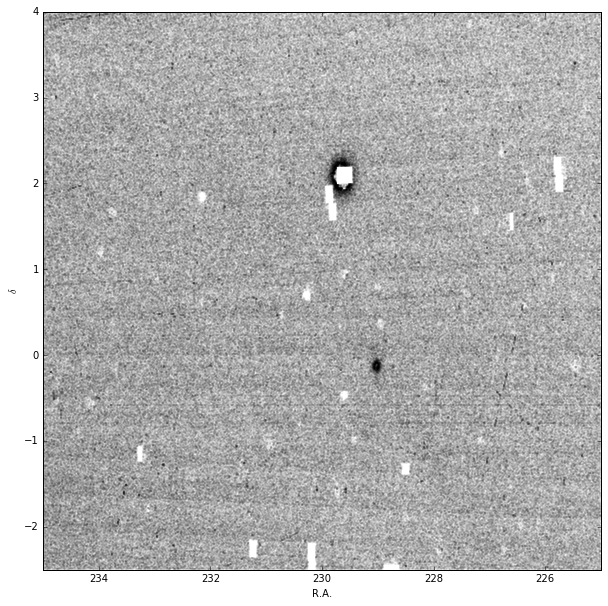

In [110]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(field_2a['ra'], field_2a['dec'], marker='.', s=0.005)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")
ax.set_xlim(225,235)
ax.set_ylim(-2.5,4)
ax.invert_xaxis()

*The object at the specified RA and Dec is the globular cluster Palomar 5.*

4
-----

Select a subset of the data in a region (a rectangle is fine!) tightly bounding the observed object. Select data in another, equally sized region, nearby but *away* from the object. Do the selection in two ways: with an SQL query of your local sqlite database, and using the indexing operators in Python (the square brackets '[]'). Show that the two give identical results (it's sufficient to show they return the same number of rows for the same constraints).

*Select area around cluster using SQL query of my database:*

In [111]:
result_pd = pd.read_sql("""
    SELECT
        dt_2a.ra, dt_2a.dec, dt_2a.g, dt_2a.r
    FROM
        dt_2a
    WHERE
        (ra < 229.2) and (ra > 228.85) and (dec < 0.05) and (dec > -0.3)
""", con)

*Select area nearby cluster using SQL query of my database:*

In [112]:
result2_pd = pd.read_sql("""
    SELECT
        dt_2a.ra, dt_2a.dec, dt_2a.g, dt_2a.r
    FROM
        dt_2a
    WHERE
        (ra < 229.65) and (ra > 229.3) and (dec < 0.05) and (dec > -0.3)
""", con)

*Select area around cluster using indexing operators in Python:*

In [113]:
result_py = dt_2a[(dt_2a['ra'] < 229.2) & (dt_2a['ra'] > 228.85) & (dt_2a['dec'] < 0.05) & (dt_2a['dec'] > -0.3)]

*Select area nearby cluster using indexing operators in Python:*

In [114]:
result2_py = dt_2a[(dt_2a['ra'] < 229.65) & (dt_2a['ra'] > 229.3) & (dt_2a['dec'] < 0.05) & (dt_2a['dec'] > -0.3)]

*Both ways of doing the selection give the same number of rows:*

In [115]:
print 'Rows in SQL query selection around cluster:   ',len(result_pd)
print 'Rows in Python query selection around cluster:',len(result_py)
print 'Rows in SQL query selection near cluster:     ',len(result2_pd)
print 'Rows in Python query selection near cluster:  ',len(result2_py)

Rows in SQL query selection around cluster:    3971
Rows in Python query selection around cluster: 3971
Rows in SQL query selection near cluster:      2062
Rows in Python query selection near cluster:   2062


*Create plotting function for RA and Dec:*

In [116]:
def add_radec(ax, data, xmin, xmax):
    ra = data['ra']
    dec = data['dec']

    ax.scatter(ra, dec, marker='.', s = 2)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)

    ax.set_xlim(xmin,xmax)
    ax.set_ylim(-0.3, 0.05)

    ax.invert_xaxis()
    ax.set_xlabel('R.A.')
    ax.set_ylabel('$\delta$')

*Plot both selected regions:*

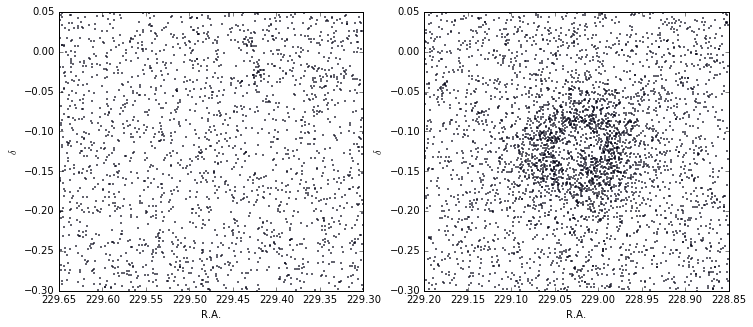

In [117]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
add_radec(ax[0], result2_py, 229.3, 229.65)
add_radec(ax[1], result_py,228.85, 229.2)

5
-----

Make two side-by-side scatter plots of the (dereddened) $g-r$ color vs $g$-band magnitude. Note that the magnitude axis, by convention, always increases from top to bottom; make sure your plot reflects that. Compare the two and describe what you see.

*Create plotting function for color-magnitude diagram:*

In [118]:
def add_cmd(ax, data):
    g = data['g']
    r = data['r']
    gr = g - r

    ax.scatter(gr, r, marker='.', s = 0.1)

    ax.set_xlim(-1, 2.5)
    ax.set_ylim(15, 22)

    ax.invert_yaxis()

    ax.set_xlabel("g - r")
    ax.set_ylabel("r")

*Plot color-magnitude diagrams for both regions:*

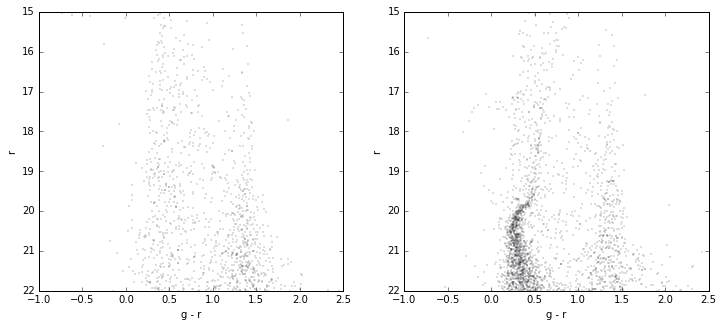

In [119]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
add_cmd(ax[0], result2_py)
add_cmd(ax[1], result_py)

*The right-hand plot shows the selection of stars centered around the cluster. You can see the main sequence feature at g-r ~ 0.4 and 19.5 < r < 22, suggesting that these stars are the related population in Palomar 5. In the plot on the left showing stars nearby but not centered on the cluster, this feature is absent.*

6
-----

Identify a region in $g-r$ vs $g$ plot where the difference between the two plots appears greatest. From your original sample, select stars only present in that *color-magnitude* box, and plot them in $ra$ vs $dec$ scatter plot. Do you notice anything interesting?

*In the color-magnitude diagrams above, the difference appears greatest in a region around 0.25 < g-r < 0.6 and r > 19.5.*

*Plot these objects in spatial coordinates:*

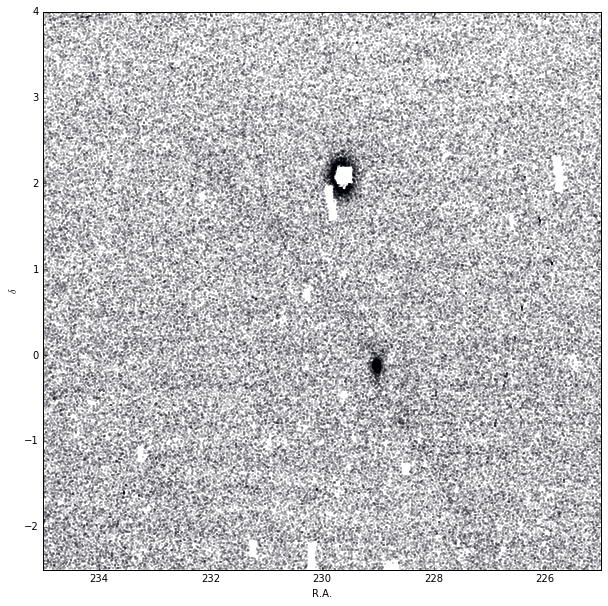

In [120]:
dt_colorcut = dt_2a[(0.25 < dt_2a['g']-dt_2a['r']) & (dt_2a['g']-dt_2a['r'] < 0.6) & (dt_2a['r'] > 19.5)]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(dt_colorcut['ra'], dt_colorcut['dec'], marker='.', s=0.18)

ax.set_xlabel("R.A.")
ax.set_ylabel("$\delta$")
ax.set_xlim(225,235)
ax.set_ylim(-2.5,4)
ax.invert_xaxis()

*Now that I have applied this color cut, Palomar 5 appears more prominently with respect to the stars around it, and there is a stream in the image which crosses the location of the globular cluster.*

7
-----

Extra credit: how would you make the determination of the $g-r$ vs $g$ selection box more quantitative?

*If you wanted to be more quantitaive about this color cut, you could create bins in color-magnitude space, and select only those regions where the density of points differ by some threshold.*

Useful links:
* http://www.sdss.org/dr12/
* http://skyserver.sdss.org/CasJobs/
* http://www.w3schools.com/sql/sql_func_count.asp
* http://en.wikipedia.org/wiki/Palomar_5

Problem 2: Importing data into the Large Survey Database
========================================================

Most users access SDSS data through the CAS database server. However, one can still download the entire catalog in bulk as a collection of FITS files from the Science Archive Server (http://dr12.sdss3.org/).

The most commonly used columns of the `PhotoObj` table in SDSS database (the photometric catalog from which views such as `Star` are derived) are stored in the so-called [*sweep files*](http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html) on the Science Archive Server. The files themselves are located in http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/ and organized by SDSS run, camera column, and the type of objects the files contain (`sky`, `star`, `gal`).

We will use these files to practice writing YAML schema files and import data into LSD.

Tasks
-----
* Install the Large Survey Database (see Lecture #3 for instructions)


In [121]:
import os

In [122]:
! conda config --add channels http://www.astro.washington.edu/users/mjuric/conda

Skipping channels: http://www.astro.washington.edu/users/mjuric/conda, item already exists


*Set LSD environment variables:*

In [123]:
os.environ['NWORKERS'] = '2'
os.environ['LSD_CACHEDIR'] = os.environ['HOME'] + '/local/tmp/lsd_tmp'
os.environ['LSD_DIR'] = os.environ['HOME'] + '/local/tmp/lsd_tmp'
os.environ['LSD_DB'] = os.environ['HOME'] + '/lsddb:/astro/apps6/opt/lsddb'
os.environ['LSD_HW1_DATADIR'] = '/local/tmp/lsd_tmp/lsd_hw1_data'

*Import LSD packages:*

In [124]:
from lsd import DB
from lsd.bounds import beam, rectangle

* Read about the [data contained in sweep files](http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html) for stars. Write a corresponding YAML LSD schema file. Make sure it consists of (at least) four tablets: basic quantities, photometry, image, resolve and calibration quantities, and the 2MASS match information. Create an LSD table with that schema.

*Saved YAML file to working directory. Here are its contents:*

In [125]:
! cat sdss_hw1.yaml

filters: {complevel: 5, complib: blosc}
schema:
  common:
    primary_key: sdss_id
    spatial_keys: [RA, DEC]
    columns:
    - [sdss_id, u8]
    - [RA, f8]
    - [DEC, f8]
    - [RUN, i2]
    - [RERUN, a3]
    - [CAMCOL, u8]
    - [FIELD, i2]
    - [ID, i2]
    - [OBJC_TYPE, i4]
    - [OBJC_FLAGS, i4]
    - [OBJC_FLAGS2, i4]
    - [OBJC_ROWC, f4]
    - [ROWVDEG, f4]
    - [ROWVDEGERR, f4]
    - [COLVDEG, f4]
    - [COLVDEGERR, f4]
    - [ROWC, 5f4]
    - [COLC, 5f4]
    - [M_RR_CC, 5f4]
    - [M_RR_CC_PSF, 5f4]
    - [FLAGS, 5i4]
    - [FLAGS2, 5i4]
    - [PSP_STATUS, 5i4]
  photometry:
    columns:
    - [EXTINCTION, 5f4]
    - [SKYFLUX, 5f4]
    - [PSFFLUX, 5f4]
    - [PSFFLUX_IVAR, 5f4]
    - [FIBERFLUX, 5f4]
    - [FIBERFLUX_IVAR, 5f4]
    - [FIBER2FLUX, 5f4]
    - [FIBER2FLUX_IVAR, 5f4]
    - [MODELFLUX, 5f4]
    - [MODELFLUX_IVAR, 5f4]
    - [CMODELFLUX_CLEAN, 5f4]
    - [CMODELFLUX_CLEAN_IVAR, 5f4]
    - [CMODELFLUX_CLEAN_VAR, 5f4]
    - [CMODELFLUX_CLEAN_CHI2, 5f4]
    - [CM

*Create an LSD table:*

In [126]:
! lsd-admin create table --drop-existing --schema sdss_hw1.yaml sdss_hw1

Table 'sdss_hw1' dropped.

-------- committing 20160224022758.537276 [sdss_hw1] ---------
[sdss_hw1] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.21 sec
[sdss_hw1] Updating neighbors: Already up to date.
[sdss_hw1] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.13 sec
[sdss_hw1] Updating stats: [0 el.]>  0.00 sec
[sdss_hw1] Marking tablets read-only...
----------- success 20160224022758.537276 [sdss_hw1] ---------

Table 'sdss_hw1' created.


*Confirm contents:*

In [127]:
! lsd-admin desc table sdss_hw1

Path:          /astro/users/hvbish/lsddb/sdss_hw1
Partitioning:  level=6
(t0, dt):      54335.000000, 1.000000 
Rows:          0
Columns:       87
Primary key:   sdss_id
Spatial keys:  (RA, DEC)
Aliases:       []
Column groups: ['common', 'photometry', 'img_res_cal', 'TMASS_match']
-------------------------------
Column group 'common':
              Column       Type
-------------------------------
             sdss_id         u8
                  RA         f8
                 DEC         f8
                 RUN         i2
               RERUN         a3
              CAMCOL         u8
               FIELD         i2
                  ID         i2
           OBJC_TYPE         i4
          OBJC_FLAGS         i4
         OBJC_FLAGS2         i4
           OBJC_ROWC         f4
             ROWVDEG         f4
          ROWVDEGERR         f4
             COLVDEG         f4
          COLVDEGERR         f4
                ROWC        5f4
                COLC        5f4
             M_RR_CC  

* Download all files belonging to run 94, from http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/. Use `lsd-import` to import these files.

*I have downloaded all of these FITS files to my working directory. Now I will import them:*

In [128]:
! lsd-import fits sdss_hw1 *.fits

Importing from 7 pieces:
  ===> Imported calibObj-000094-1-star.fits                                            [1/7, 14.29%] + 133515/133515     133515 (0/1 min.)
  ===> Imported calibObj-000094-2-star.fits                                            [2/7, 28.57%] + 155355/155355     288870 (0/0 min.)
  ===> Imported calibObj-000094-4-star.fits                                            [3/7, 42.86%] + 130027/130027     418897 (0/1 min.)
  ===> Imported calibObj-000094-3-star.fits                                            [4/7, 57.14%] + 124832/124832     543729 (0/0 min.)
  ===> Imported calibObj-000094-5-star.fits                                            [5/7, 71.43%] + 136292/136292     680021 (0/0 min.)
Remote Traceback (most recent call last):
  File "/astro/apps6/opt/anaconda2.4/lib/python2.7/site-packages/lsd/pool2.py", line 85, in _worker
    for result in mapper(item, *mapper_args):
  File "/astro/apps6/opt/anaconda2.4/bin/lsd-import", line 20, in import_from_chunks_aux
   

* Use `lsd-footprint` to compute the footprint of the run, and plot the result.

In [129]:
! lsd-footprint sdss_hw1 footprint.fits

 [0 el.]>  0.00 sec
Objects: 0.0


*Get data from footprint FITS file:*

In [130]:
from astropy.io import fits
#foot = fits.open('footprint.fits')[0].data
footprint = fits.getdata('footprint.fits')

*Plot footprint:*

(2665, 2745)

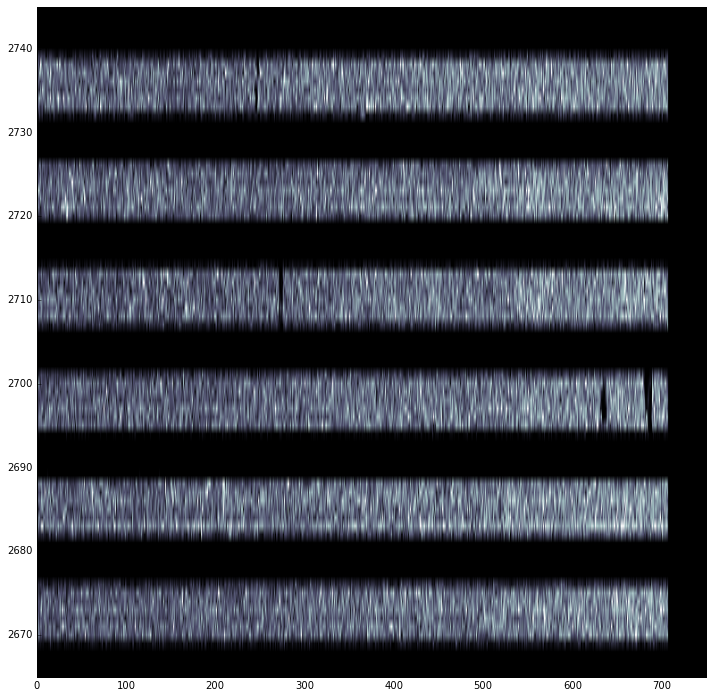

In [131]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(foot,aspect='auto',cmap='bone',vmin=0,vmax=20)
ax.set_xlim([0,750])
ax.set_ylim([2665,2745])

Useful links:
* http://dr12.sdss3.org/datamodel/
* http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html
* http://lsddb.org